In [1]:
from ccDGGeom import np, Point, Rectangle, Line

In [2]:
from matplotlib import pyplot as plot

In [3]:
room1 = Rectangle(2, 2, 8, 4)
room2 = Rectangle(16, 2, 8, 10)
room3 = Rectangle(4, 8, 7, 5)
hall1 = Line(9, 3, 8, 'e')
hall2 = Line(16, 8, 4, 'w')
hall3 = Line(10, 11, 4, 'e')
hall4 = Line(13, 8, 4, 's')
rooms = (room1, room2, room3)
halls = (hall1, hall2, hall3, hall4)

In [4]:
pMax = Point(0, 0)

for r in rooms:
    f = r.getMinFrame()
    if np.any(f.npar > pMax.npar):
        pMax = Point(max(f.x, pMax.x), max(f.y, pMax.y))

for h in halls:
    f = h.getMinFrame()
    if np.any(f.npar > pMax.npar):
        pMax = Point(max(f.x, pMax.x), max(f.y, pMax.y))
        
pMax

(24, 13)

In [5]:
frame = Point(28, 16)

In [6]:
maskR = np.zeros(frame.npar, bool)
for r in rooms:
    maskR |= r.getMaskEdge(frame.x, frame.y)
maskH = np.zeros(frame.npar, bool)
for h in halls:
    maskH |= h.getMask(frame.x, frame.y)
    
maskR, maskH, maskR | maskH

(array([[_, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _],
        [_, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _],
        [_, _, #, #, #, #, #, #, #, #, _, _, _, _, _, _, #, #, #, #, #, #, #, #, _, _, _, _],
        [_, _, #, _, _, _, _, _, _, #, _, _, _, _, _, _, #, _, _, _, _, _, _, #, _, _, _, _],
        [_, _, #, _, _, _, _, _, _, #, _, _, _, _, _, _, #, _, _, _, _, _, _, #, _, _, _, _],
        [_, _, #, #, #, #, #, #, #, #, _, _, _, _, _, _, #, _, _, _, _, _, _, #, _, _, _, _],
        [_, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, #, _, _, _, _, _, _, #, _, _, _, _],
        [_, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _, #, _, _, _, _, _, _, #, _, _, _, _],
        [_, _, _, _, #, #, #, #, #, #, #, _, _, _, _, _, #, _, _, _, _, _, _, #, _, _, _, _],
        [_, _, _, _, #, _, _, _, _, _, #, _, _, _, _, _, #, _, _, _, _, _, _, #, _, _, _, _],
        [_, _, _, _, #, _, _, _, _, _, #, _, _, _, _, _, #, 

In [20]:
class Catacombs:
    def __init__(
        self, w : int, h : int,
        rct : int, conn : int,
        raap : float,
        varix : int, variy : int,
        padx : int = 0, pady : int = 0
    ):
        self.size = Point(w, h)
        self.roomCount = rct
        self.hallAvgCount = conn
        self.roomAvgAreaPercent = raap
        self.variance = Point(varix, variy)
        self.padding = Point(padx, pady)
        
        adim = (self.size.npar * np.sqrt(self.roomAvgAreaPercent)).astype(int)
        self.roomAvgDim = Point(adim[1], adim[0])
        
        self.rooms = []
        self.halls = []
        
    def __str__(self) -> str:
        return (
            "A {} wide by {} tall dungeon,\n" \
            + "with {} rooms of about {:02.0f}% average area each,\n" \
            + "or of average dimension {} wide by {} tall,\n" \
            + "with an average of {} hallways out of each room;\n" \
            + "Rooms are padded by at least {} East-West & {} North-South,\n"
            + "and have a length variance of +/-{} wide and +/- {} tall."
        ).format(
            self.size.x, self.size.y,
            self.roomCount, self.roomAvgAreaPercent * 100.,
            self.roomAvgDim.x, self.roomAvgDim.y,
            self.hallAvgCount,
            self.padding.x, self.padding.y,
            self.variance.x, self.variance.y
        )
    
    def __repr__(self) -> str:
        return self.__str__()
    
    def genRooms(self, reset = False, attemptsOverride : int = 0):
        if not reset:
            return
        
        self.rooms = []
        attempts = 0
        if attemptsOverride > 0:
            maxAttempts = attemptsOverride
        else:
            maxAttempts = int(
                10. ** (-np.log(1. - self.roomCount * self.roomAvgAreaPercent) + np.e)
            )
        
        while len(self.rooms) < self.roomCount:
            attempts += 1
            noise = np.random.randint(
                -self.variance.npar[::-1], self.variance.npar[::-1] + 1, 2
            )
            newSize = Point(*np.maximum(
                self.roomAvgDim.npar[::-1] + noise,
                np.zeros(2, int) + 4
            ))
            originSpace = self.size - newSize
            newOrigin = Point(*np.random.randint(np.zeros(2, int), originSpace.tupl, 2))
            newRoom = Rectangle(newOrigin.x, newOrigin.y, newSize.x, newSize.y)
            newRoomPadZone = Rectangle(
                max(newOrigin.x - self.padding.x, 0),
                max(newOrigin.y - self.padding.y, 0),
                newSize.x + 2 * self.padding.x,
                newSize.y + 2 * self.padding.y
            )
            
            nonOverlapping = True
            for r in self.rooms:
                if newRoomPadZone & r:
                    nonOverlapping = False
                    break
            
            if nonOverlapping:
                self.rooms.append(newRoom)
                print(noise, newSize, newOrigin)
                print(newRoom)
                print(newRoomPadZone)
                print()
                
            if attempts > maxAttempts:
                if len(self.rooms) < self.roomCount:
                    print("Warning: maximum room generation attempts reached.")
                    print("Your dungeon will only have", len(self.rooms), "rooms")
                break
        
        print("Attemped room generations", attempts, "times.")
                
    def draw(self) -> np.array:
        mask = np.zeros(self.size.npar, bool)
        for r in self.rooms:
            mask |= r.getMaskEdge(self.size.x, self.size.y)
        for h in self.halls:
            mask |= h.getMask(self.size.x, self.size.y)
            
        return mask

In [22]:
c = Catacombs(100, 60, 8, 2, 0.08, 12, 2, 3, 3)
c

A 100 wide by 60 tall dungeon,
with 8 rooms of about 08% average area each,
or of 28 wide by 16 tall average dimension,
with an average of 2 hallways out of each room;
Rooms are padded by at least 3 East-West & 3 North-South,
and have a length variance of +/-12 wide and +/- 2 tall.

[1 1] (29, 17) (65, 30)
A   29 by   17 Rectangle cornered at (  65,   30).
A   35 by   23 Rectangle cornered at (  62,   27).

[-8  2] (20, 18) (21, 29)
A   20 by   18 Rectangle cornered at (  21,   29).
A   26 by   24 Rectangle cornered at (  18,   26).

[8 0] (36, 16) (24, 0)
A   36 by   16 Rectangle cornered at (  24,    0).
A   42 by   22 Rectangle cornered at (  21,    0).

[-8  0] (20, 16) (67, 5)
A   20 by   16 Rectangle cornered at (  67,    5).
A   26 by   22 Rectangle cornered at (  64,    2).

[-12  -1] (16, 15) (45, 38)
A   16 by   15 Rectangle cornered at (  45,   38).
A   22 by   21 Rectangle cornered at (  42,   35).

[-11   0] (17, 16) (2, 0)
A   17 by   16 Rectangle cornered at (   2,    0).
A   23 by   22 Rectangle cornered at (   0,    0).

[-12  -1] (16, 15) (44, 19)
A   16 by   15 Rectangle cornered at (  44,   19).
A   22 by   21 Rectangle cornered at (  41,   16).

Your dungeon will only have 7 rooms
Attemped room generations 5495 times.


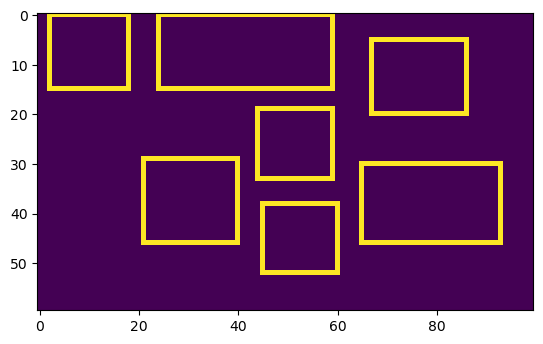

[12 -2] (40, 14) (17, 37)
A   40 by   14 Rectangle cornered at (  17,   37).
A   46 by   20 Rectangle cornered at (  14,   34).

[-7  0] (21, 16) (6, 8)
A   21 by   16 Rectangle cornered at (   6,    8).
A   27 by   22 Rectangle cornered at (   3,    5).

[8 0] (36, 16) (36, 0)
A   36 by   16 Rectangle cornered at (  36,    0).
A   42 by   22 Rectangle cornered at (  33,    0).

[3 2] (31, 18) (61, 41)
A   31 by   18 Rectangle cornered at (  61,   41).
A   37 by   24 Rectangle cornered at (  58,   38).

[3 0] (31, 16) (65, 21)
A   31 by   16 Rectangle cornered at (  65,   21).
A   37 by   22 Rectangle cornered at (  62,   18).

[-8 -2] (20, 14) (78, 3)
A   20 by   14 Rectangle cornered at (  78,    3).
A   26 by   20 Rectangle cornered at (  75,    0).

[-11  -2] (17, 14) (34, 19)
A   17 by   14 Rectangle cornered at (  34,   19).
A   23 by   20 Rectangle cornered at (  31,   16).

Your dungeon will only have 7 rooms
Attemped room generations 5495 times.


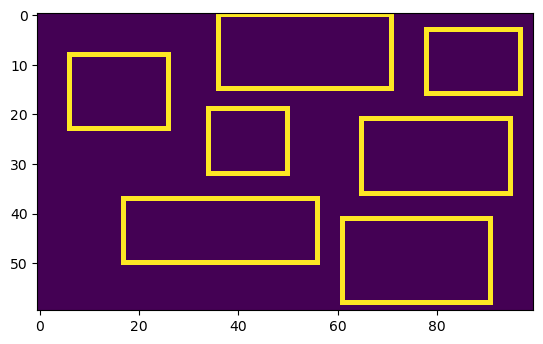

[5 0] (33, 16) (14, 11)
A   33 by   16 Rectangle cornered at (  14,   11).
A   39 by   22 Rectangle cornered at (  11,    8).

[10  1] (38, 17) (56, 4)
A   38 by   17 Rectangle cornered at (  56,    4).
A   44 by   23 Rectangle cornered at (  53,    1).

[-2  0] (26, 16) (69, 29)
A   26 by   16 Rectangle cornered at (  69,   29).
A   32 by   22 Rectangle cornered at (  66,   26).

[6 0] (34, 16) (11, 40)
A   34 by   16 Rectangle cornered at (  11,   40).
A   40 by   22 Rectangle cornered at (   8,   37).

[-11  -1] (17, 15) (49, 44)
A   17 by   15 Rectangle cornered at (  49,   44).
A   23 by   21 Rectangle cornered at (  46,   41).

Your dungeon will only have 5 rooms
Attemped room generations 5495 times.


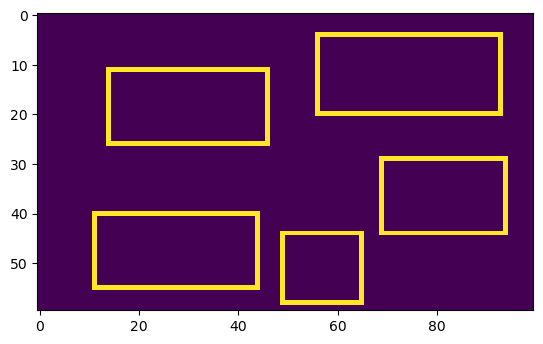

[ 9 -1] (37, 15) (18, 18)
A   37 by   15 Rectangle cornered at (  18,   18).
A   43 by   21 Rectangle cornered at (  15,   15).

[-8  0] (20, 16) (13, 37)
A   20 by   16 Rectangle cornered at (  13,   37).
A   26 by   22 Rectangle cornered at (  10,   34).

[ 3 -1] (31, 15) (53, 37)
A   31 by   15 Rectangle cornered at (  53,   37).
A   37 by   21 Rectangle cornered at (  50,   34).

[-5 -1] (23, 15) (61, 8)
A   23 by   15 Rectangle cornered at (  61,    8).
A   29 by   21 Rectangle cornered at (  58,    5).

Your dungeon will only have 4 rooms
Attemped room generations 5495 times.


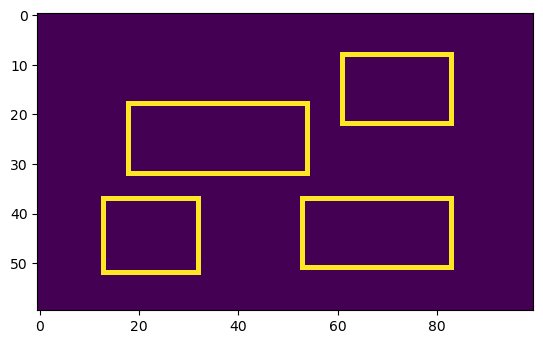

[5 2] (33, 18) (17, 6)
A   33 by   18 Rectangle cornered at (  17,    6).
A   39 by   24 Rectangle cornered at (  14,    3).

[-5 -2] (23, 14) (65, 27)
A   23 by   14 Rectangle cornered at (  65,   27).
A   29 by   20 Rectangle cornered at (  62,   24).

[ 5 -1] (33, 15) (9, 35)
A   33 by   15 Rectangle cornered at (   9,   35).
A   39 by   21 Rectangle cornered at (   6,   32).

[-3  1] (25, 17) (68, 1)
A   25 by   17 Rectangle cornered at (  68,    1).
A   31 by   23 Rectangle cornered at (  65,    0).

[10 -2] (38, 14) (51, 44)
A   38 by   14 Rectangle cornered at (  51,   44).
A   44 by   20 Rectangle cornered at (  48,   41).

Your dungeon will only have 5 rooms
Attemped room generations 5495 times.


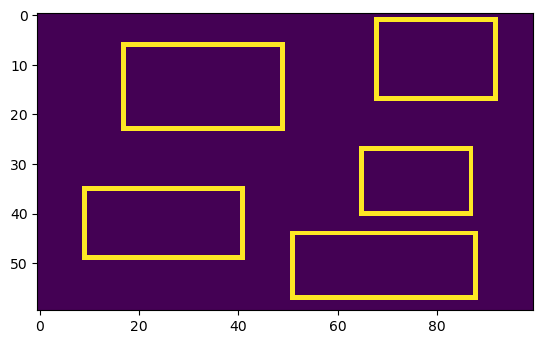

[-2 -1] (26, 15) (5, 0)
A   26 by   15 Rectangle cornered at (   5,    0).
A   32 by   21 Rectangle cornered at (   2,    0).

[-4  0] (24, 16) (6, 21)
A   24 by   16 Rectangle cornered at (   6,   21).
A   30 by   22 Rectangle cornered at (   3,   18).

[ 3 -2] (31, 14) (40, 5)
A   31 by   14 Rectangle cornered at (  40,    5).
A   37 by   20 Rectangle cornered at (  37,    2).

[ 1 -1] (29, 15) (45, 38)
A   29 by   15 Rectangle cornered at (  45,   38).
A   35 by   21 Rectangle cornered at (  42,   35).

[-12  -2] (16, 14) (75, 1)
A   16 by   14 Rectangle cornered at (  75,    1).
A   22 by   20 Rectangle cornered at (  72,    0).

[-4  2] (24, 18) (7, 41)
A   24 by   18 Rectangle cornered at (   7,   41).
A   30 by   24 Rectangle cornered at (   4,   38).

[-11  -1] (17, 15) (80, 28)
A   17 by   15 Rectangle cornered at (  80,   28).
A   23 by   21 Rectangle cornered at (  77,   25).

Your dungeon will only have 7 rooms
Attemped room generations 5495 times.


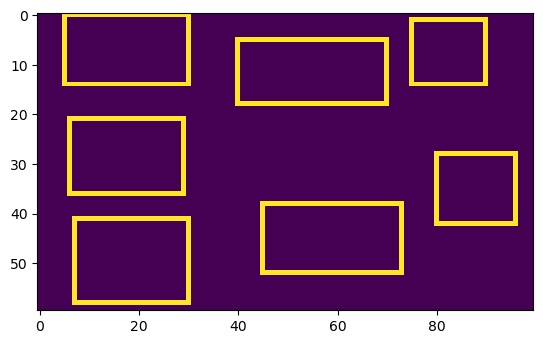

[-2 -2] (26, 14) (21, 44)
A   26 by   14 Rectangle cornered at (  21,   44).
A   32 by   20 Rectangle cornered at (  18,   41).

[ 6 -2] (34, 14) (34, 25)
A   34 by   14 Rectangle cornered at (  34,   25).
A   40 by   20 Rectangle cornered at (  31,   22).

[-7  1] (21, 17) (13, 0)
A   21 by   17 Rectangle cornered at (  13,    0).
A   27 by   23 Rectangle cornered at (  10,    0).

[-9 -1] (19, 15) (59, 5)
A   19 by   15 Rectangle cornered at (  59,    5).
A   25 by   21 Rectangle cornered at (  56,    2).

[-8 -2] (20, 14) (50, 45)
A   20 by   14 Rectangle cornered at (  50,   45).
A   26 by   20 Rectangle cornered at (  47,   42).

[-7  2] (21, 18) (77, 24)
A   21 by   18 Rectangle cornered at (  77,   24).
A   27 by   24 Rectangle cornered at (  74,   21).

[-2  0] (26, 16) (5, 21)
A   26 by   16 Rectangle cornered at (   5,   21).
A   32 by   22 Rectangle cornered at (   2,   18).

[-10  -2] (18, 14) (37, 3)
A   18 by   14 Rectangle cornered at (  37,    3).
A   24 by   20 Rectang

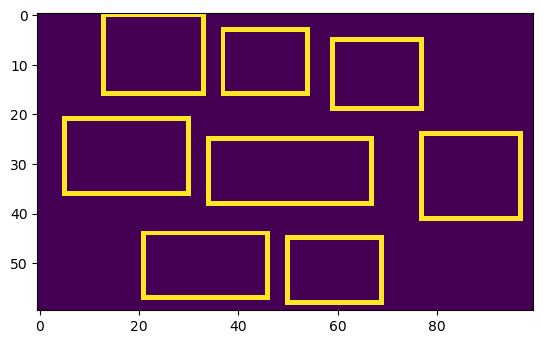

[ 5 -1] (33, 15) (32, 7)
A   33 by   15 Rectangle cornered at (  32,    7).
A   39 by   21 Rectangle cornered at (  29,    4).

[-6 -1] (22, 15) (10, 38)
A   22 by   15 Rectangle cornered at (  10,   38).
A   28 by   21 Rectangle cornered at (   7,   35).

[10 -1] (38, 15) (60, 27)
A   38 by   15 Rectangle cornered at (  60,   27).
A   44 by   21 Rectangle cornered at (  57,   24).

[-9  1] (19, 17) (2, 11)
A   19 by   17 Rectangle cornered at (   2,   11).
A   25 by   23 Rectangle cornered at (   0,    8).

[-12   2] (16, 18) (38, 41)
A   16 by   18 Rectangle cornered at (  38,   41).
A   22 by   24 Rectangle cornered at (  35,   38).

[-12   1] (16, 17) (83, 3)
A   16 by   17 Rectangle cornered at (  83,    3).
A   22 by   23 Rectangle cornered at (  80,    0).

[-8 -2] (20, 14) (76, 45)
A   20 by   14 Rectangle cornered at (  76,   45).
A   26 by   20 Rectangle cornered at (  73,   42).

Your dungeon will only have 7 rooms
Attemped room generations 5495 times.


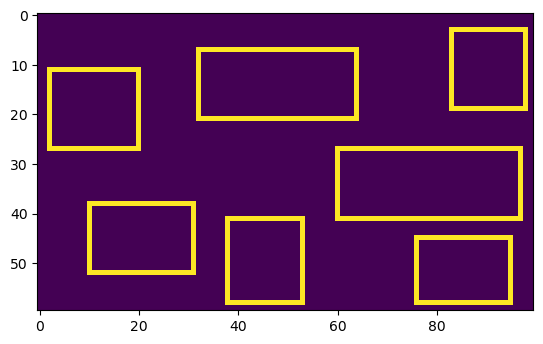

[ 6 -2] (34, 14) (18, 22)
A   34 by   14 Rectangle cornered at (  18,   22).
A   40 by   20 Rectangle cornered at (  15,   19).

[ 1 -2] (29, 14) (23, 44)
A   29 by   14 Rectangle cornered at (  23,   44).
A   35 by   20 Rectangle cornered at (  20,   41).

[-5  2] (23, 18) (66, 20)
A   23 by   18 Rectangle cornered at (  66,   20).
A   29 by   24 Rectangle cornered at (  63,   17).

[-7 -1] (21, 15) (57, 43)
A   21 by   15 Rectangle cornered at (  57,   43).
A   27 by   21 Rectangle cornered at (  54,   40).

[-9 -1] (19, 15) (16, 3)
A   19 by   15 Rectangle cornered at (  16,    3).
A   25 by   21 Rectangle cornered at (  13,    0).

[11 -2] (39, 14) (50, 3)
A   39 by   14 Rectangle cornered at (  50,    3).
A   45 by   20 Rectangle cornered at (  47,    0).

[-12   2] (16, 18) (0, 39)
A   16 by   18 Rectangle cornered at (   0,   39).
A   22 by   24 Rectangle cornered at (   0,   36).

[-10  -2] (18, 14) (81, 45)
A   18 by   14 Rectangle cornered at (  81,   45).
A   24 by   20 Rect

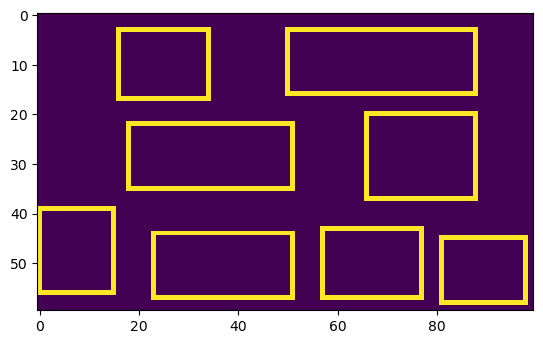

[7 2] (35, 18) (35, 22)
A   35 by   18 Rectangle cornered at (  35,   22).
A   41 by   24 Rectangle cornered at (  32,   19).

[-6  1] (22, 17) (2, 14)
A   22 by   17 Rectangle cornered at (   2,   14).
A   28 by   23 Rectangle cornered at (   0,   11).

[ 2 -2] (30, 14) (7, 44)
A   30 by   14 Rectangle cornered at (   7,   44).
A   36 by   20 Rectangle cornered at (   4,   41).

[ 5 -1] (33, 15) (54, 2)
A   33 by   15 Rectangle cornered at (  54,    2).
A   39 by   21 Rectangle cornered at (  51,    0).

[-8 -2] (20, 14) (45, 45)
A   20 by   14 Rectangle cornered at (  45,   45).
A   26 by   20 Rectangle cornered at (  42,   42).

[-7 -1] (21, 15) (78, 26)
A   21 by   15 Rectangle cornered at (  78,   26).
A   27 by   21 Rectangle cornered at (  75,   23).

[-8  0] (20, 16) (30, 2)
A   20 by   16 Rectangle cornered at (  30,    2).
A   26 by   22 Rectangle cornered at (  27,    0).

[-11  -2] (17, 14) (69, 44)
A   17 by   14 Rectangle cornered at (  69,   44).
A   23 by   20 Rectangle

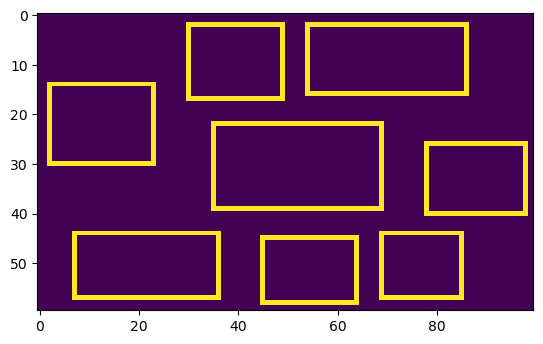

In [23]:
for i in range(10):
    c.genRooms(reset = True)
    plot.imshow(c.draw())
    plot.show()

In [10]:
v = np.random.randint(-5, 5 + 1, 2).tolist()
Point(v[0], v[1])

(4, 3)

In [11]:
?cv.imshow

Object `cv.imshow` not found.


In [12]:
np.random.randint([-10, -2], [11, 3], 2)

array([-10,   1])

In [13]:
-np.log(np.linspace(0.05, 1., 20))

array([ 2.996,  2.303,  1.897,  1.609,  1.386,  1.204,  1.05 ,  0.916,  0.799,  0.693,  0.598,  0.511,  0.431,  0.357,  0.288,
        0.223,  0.163,  0.105,  0.051, -0.   ])

In [14]:
(10. ** (_ + 2.)).astype(int), (10. ** (_ + 2.71)).astype(int)

(array([99022, 20071,  7890,  4068,  2433,  1599,  1121,   824,   628,   493,   396,   324,   269,   227,   193,   167,   145,
          127,   112,   100]),
 array([507846, 102940,  40468,  20865,  12482,   8203,   5752,   4229,   3224,   2530,   2031,   1662,   1382,   1165,    994,
           857,    745,    653,    577,    512]))

In [15]:
np.e

2.718281828459045